# Neural Networks Sprint Challenge

## 1) Define the following terms:

- Neuron
- Input Layer
- Hidden Layer
- Output Layer
- Activation
- Backpropagation

- Neuron is known as node in a Neural Network. It was inspired by how neural networks in the brain process information.  It takes each of the input values, multplies each of them by a weight, sums all of these products up, and then passes the sum through what is called an "activation function" the result of which is the final value.
- Input Layer is the layer that receives input from our dataset. It is also called the visible layer.
- Hidden Layer is the layer between the input and output layers. They're inside of the network and they perform their assigned functions, but we don't directly interact with them.
- Output Layer is the final layer of a Neural Network and its function is to output a vector of values that answer the problem that we're trying to address
- Activation Function is also known as the transfer function and it decide how much signal to pass onto the next layer.  In Neural Networks, each node has an activation function.
- Backpropagation is short for "Backwards Propagation of errors" and refers to a specific algorithm for how weights in a neural network are updated in reverse order at the end of each training epoch.

## 2) Create a perceptron class that can model the behavior of an AND gate. You can use the following table as your training data:

| x1 | x2 | x3 | y |
|----|----|----|---|
| 1  | 1  | 1  | 1 |
| 1  | 0  | 1  | 0 |
| 0  | 1  | 1  | 0 |
| 0  | 0  | 1  | 0 |

In [30]:
import numpy as np
X = np.array([[1,1,1],
              [1,0,1],
              [0,1,1],
              [0,0,1]])

y = [[1], 
     [0],
     [0],
     [0]]

print(len(y), X.shape)
print(type(y), type(X))
print("-"*100)

class Perceptron(object):
  def __init__(self, rate = 0.01, niter = 10):
    self.rate = rate
    self.niter = niter

  def fit(self, X, y):
    """Fit training data
    X : Training vectors, X.shape : [#samples, #features]
    y : Target values, y.shape : [#samples]
    """

    # weights
    self.weight = np.zeros(1 + X.shape[1])

    # Number of misclassifications
    self.errors = []  # Number of misclassifications

    for i in range(self.niter):
      err = 0
      for xi, target in zip(X, y):
        delta_w = self.rate * (target - self.predict(xi))
        self.weight[1:] += delta_w * xi
        self.weight[0] += delta_w
        err += int(delta_w != 0.0)
      self.errors.append(err)
    return self

  def net_input(self, X):
    """Calculate net input"""
    return np.dot(X, self.weight[1:]) + self.weight[0]

  def predict(self, X):
    """Return class label after unit step"""
    return np.where(self.net_input(X) >= 0.5, 1, 0)

model = Perceptron(0.1, 10)
model.fit(X, y)
model.predict(X)

4 (4, 3)
<class 'list'> <class 'numpy.ndarray'>
----------------------------------------------------------------------------------------------------


array([1, 0, 0, 0])

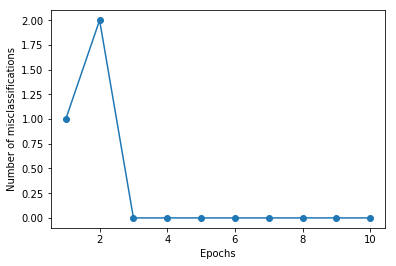

In [31]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(model.errors) + 1), model.errors, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.show()

## 3) Implement a Neural Network Multilayer Perceptron class that uses backpropagation to update the network's weights. 
- Your network must have one hidden layer. 
- You do not have to update weights via gradient descent. You can use something like the derivative of the sigmoid function to update weights.
- Train your model on the Heart Disease dataset from UCI:

[Github Dataset](https://github.com/ryanleeallred/datasets/blob/master/heart.csv)

[Raw File on Github](https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv)


### Preview

In [32]:
import pandas as pd
df=pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [33]:
print("df shape:"), print(df.shape), print("---"*20)
print("df columns:"), print(df.columns), print("---"*20)
print("df dtypes.sort_values(ascending=False):"), print(
    df.dtypes.sort_values(ascending=False)), print("---"*20)
print("df isna().sum().sort_values(ascending=False):"), print(
    df.isna().sum().sort_values(ascending=False)), print("---"*20)
df.describe().T

df shape:
(303, 14)
------------------------------------------------------------
df columns:
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
------------------------------------------------------------
df dtypes.sort_values(ascending=False):
oldpeak     float64
target        int64
thal          int64
ca            int64
slope         int64
exang         int64
thalach       int64
restecg       int64
fbs           int64
chol          int64
trestbps      int64
cp            int64
sex           int64
age           int64
dtype: object
------------------------------------------------------------
df isna().sum().sort_values(ascending=False):
target      0
thal        0
ca          0
slope       0
oldpeak     0
exang       0
thalach     0
restecg     0
fbs         0
chol        0
trestbps    0
cp          0
sex         0
age         0
dtype: int64
-------------------------------------

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


### Functions

In [34]:
import numpy as np

class Neural_Network(object):
  def __init__(self):
    self.inputs = 13 # represent input column shape
    self.hiddenNodes = 16
    self.outputNodes = 1 # represent output column shape

    # Initlize Weights
    self.L1_weights = np.random.randn(self.inputs, self.hiddenNodes) # (3x16)
    self.L2_weights = np.random.randn(self.hiddenNodes, self.outputNodes) # (16x1)

  def feed_forward(self, X):
    # Weighted sum between inputs and hidden layer
    self.hidden_sum = np.dot(X, self.L1_weights)
    # Activations of weighted sum
    self.activated_hidden = self.sigmoid(self.hidden_sum)
    # Weighted sum between hidden and output
    self.output_sum = np.dot(self.activated_hidden, self.L2_weights)
    # final activation of output
    self.activated_output = self.sigmoid(self.output_sum)
    return self.activated_output
    
  def sigmoid(self, s):
    return 1/(1+np.exp(-s))
  
  def sigmoidPrime(self, s):
    return s * (1 - s)
  
  def backward(self, X, y, o):
    # backward propgate through the network
    self.o_error = y - o # error in output
    self.o_delta = self.o_error*self.sigmoidPrime(o) # applying derivative of sigmoid to error

    self.z2_error = self.o_delta.dot(self.L2_weights.T) # z2 error: how much our hidden layer weights contributed to output error
    self.z2_delta = self.z2_error*self.sigmoidPrime(self.activated_hidden) # applying derivative of sigmoid to z2 error

    self.L1_weights += X.T.dot(self.z2_delta) # adjusting first set (input --> hidden) weights
    self.L2_weights += self.activated_hidden.T.dot(self.o_delta) # adjusting second set (hidden --> output) weights
    
  def train (self, X, y):
    o = self.feed_forward(X)
    self.backward(X, y, o)

### Run Model

In [35]:
# Split data
################################ 
y = df.target.values
# convert y to list of array
y_expanded = []
for idx, num in enumerate(y):
    y_expanded.append([num])
y = y_expanded.copy()

X = df.drop(columns = ['target']).values

print(len(y), X.shape)
print(type(y), type(X))
print("-"*100)

# Run Model
################################ 

model = Neural_Network()
for i in range(1000): # trains the NN 1,000 times
    if i+1 in [1,2,3,4,5] or (i+1) % 50 == 0:
        print('+---------- EPOCH', i+1, '-----------+')
        print("Input: \n", X) 
        print("Actual Output: \n", y)    
        print("Predicted Output: \n" + str(model.feed_forward(X))) 
        print("Loss: \n" + str(np.mean(np.square(y - model.feed_forward(X))))) # mean sum squared loss
        print("\n")
    model.train(X, y)

303 (303, 13)
<class 'list'> <class 'numpy.ndarray'>
----------------------------------------------------------------------------------------------------
+---------- EPOCH 1 -----------+
Input: 
 [[63.  1.  3. ...  0.  0.  1.]
 [37.  1.  2. ...  0.  0.  2.]
 [41.  0.  1. ...  2.  0.  2.]
 ...
 [68.  1.  0. ...  1.  2.  3.]
 [57.  1.  0. ...  1.  1.  3.]
 [57.  0.  1. ...  1.  1.  2.]]
Actual Output: 
 [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

Predicted Output: 
[[1.71449341e-04]
 [8.27714947e-05]
 [1.71449341e-04]
 [1.71449341e-04]
 [8.27710691e-05]
 [1.71449341e-04]
 [1.71449341e-04]
 [8.27738438e-05]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449149e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [8.27710664e-05]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71448855e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [8.27804650e-05]
 [1.71449341e-04]
 [1.09189200e-04]
 [1.71449341e-04]
 [1.71449257e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71389422e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449314e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [8.27710625e-05]
 [8.27710626e-05]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [1.71449341e-04]
 [3.65688942e-04]
 [1.71449

Predicted Output: 
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

+---------- EPOCH 200 -----------+
Input: 
 [[63.  1.  3. ...  0.  0.  1.]
 [37.  1.  2. ...  0.  0.  2.]
 [41.  0.  1. ...  2.  0.  2.]
 ...
 [68.  1.  0. ...  1.  2.  3.]
 [57.  1.  0. ...  1.  1.  3.]
 [57.  0.  1. ...  1.  1.  2.]]
Actual Output: 
 [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [

Predicted Output: 
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

Predicted Output: 
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

Loss: 
0.45544554455445546


+---------- EPOCH 750 -----------+
Input: 
 [[63.  1.  3. ...  0.  0.  1.]
 [37.  1.  2. ...  0.  0.  2.]
 [41.  0.  1. ...  2.  0.  2.]
 ...
 [68.  1.  0. ...  1.  2.  3.]
 [57.  1.  0. ...  1.  1.  3.]
 [57.  0.  1. ...  1.  1.  2.]]
Actual Output: 
 [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1

+---------- EPOCH 900 -----------+
Input: 
 [[63.  1.  3. ...  0.  0.  1.]
 [37.  1.  2. ...  0.  0.  2.]
 [41.  0.  1. ...  2.  0.  2.]
 ...
 [68.  1.  0. ...  1.  2.  3.]
 [57.  1.  0. ...  1.  1.  3.]
 [57.  0.  1. ...  1.  1.  2.]]
Actual Output: 
 [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [

## 4) Implement a Multilayer Perceptron architecture of your choosing using the Keras library. Train your model and report its baseline accuracy. Then hyperparameter tune at least two parameters and report your model's accuracy. 

- Use the Heart Disease Dataset (binary classification)
- Use an appropriate loss function for a binary classification task
- Use an appropriate activation function on the final layer of your network. 
- Train your model using verbose output for ease of grading.
- Use GridSearchCV to hyperparameter tune your model. (for at least two hyperparameters)
- When hyperparameter tuning, show you work by adding code cells for each new experiment. 
- Report the accuracy for each combination of hyperparameters as you test them so that we can easily see which resulted in the highest accuracy.
- You must hyperparameter tune at least 5 parameters in order to get a 3 on this section.

### Standardize Data

In [36]:
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df=pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv')

X = df.drop('target', axis=1)
y = df['target']

# Scale input data
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)

[[ 0.9521966   0.68100522  1.97312292 ... -2.27457861 -0.71442887
  -2.14887271]
 [-1.91531289  0.68100522  1.00257707 ... -2.27457861 -0.71442887
  -0.51292188]
 [-1.47415758 -1.46841752  0.03203122 ...  0.97635214 -0.71442887
  -0.51292188]
 ...
 [ 1.50364073  0.68100522 -0.93851463 ... -0.64911323  1.24459328
   1.12302895]
 [ 0.29046364  0.68100522 -0.93851463 ... -0.64911323  0.26508221
   1.12302895]
 [ 0.29046364 -1.46841752  0.03203122 ... -0.64911323  0.26508221
  -0.51292188]]


/home/superio/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/superio/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Baseline Model

In [37]:
from keras.models import Sequential
from keras.layers import Dense

# Hyperparameters
inputs = X.shape[1]
epochs = 20
batch_size = 80

# Create model
model = Sequential()
model.add(Dense(24, activation='relu', input_shape=(inputs,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Fit model
model.summary()
model.fit(X, y, validation_split=0.2, epochs=epochs, batch_size=batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_232 (Dense)            (None, 24)                336       
_________________________________________________________________
dense_233 (Dense)            (None, 16)                400       
_________________________________________________________________
dense_234 (Dense)            (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________
Train on 242 samples, validate on 61 samples
Epoch 1/20
242/242 [==============================] - 37s 154ms/step - loss: 0.3449 - acc: 0.3306 - val_loss: 0.1668 - val_acc: 0.9344
Epoch 2/20
242/242 [==============================] - 0s 254us/step - loss: 0.3266 - acc: 0.3388 - val_loss: 0.1805 - val_acc: 0.9180
Epoch 3/20
242/242 [==============================] - 0s 221us/step - loss: 0.3103 - acc: 0.34

### Hyperparameters Tuning

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=(inputs,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

# define cross validation test harness -
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define the grid search parameters
param_grid = {'batch_size': [20, 30, 40, 80],
              'epochs': [20, 40, 60]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=kfold)
grid_result = grid.fit(X, y)

Epoch 1/20
202/202 [==============================] - 6s 28ms/step - loss: 0.6696 - acc: 0.6040
Epoch 2/20
202/202 [==============================] - 0s 492us/step - loss: 0.6271 - acc: 0.6980
Epoch 3/20
202/202 [==============================] - 0s 653us/step - loss: 0.5921 - acc: 0.7723
Epoch 4/20
202/202 [==============================] - 0s 744us/step - loss: 0.5629 - acc: 0.8069
Epoch 5/20
202/202 [==============================] - 0s 600us/step - loss: 0.5336 - acc: 0.8267
Epoch 6/20
202/202 [==============================] - 0s 843us/step - loss: 0.5054 - acc: 0.8366
Epoch 7/20
202/202 [==============================] - 0s 800us/step - loss: 0.4786 - acc: 0.8366
Epoch 8/20
202/202 [==============================] - 0s 733us/step - loss: 0.4531 - acc: 0.8317
Epoch 9/20
202/202 [==============================] - 0s 698us/step - loss: 0.4310 - acc: 0.8366
Epoch 10/20
202/202 [==============================] - 0s 940us/step - loss: 0.4114 - acc: 0.8564
Epoch 11/20
202/202 [=========

202/202 [==============================] - 0s 718us/step - loss: 0.3109 - acc: 0.8614
Epoch 22/40
202/202 [==============================] - 0s 776us/step - loss: 0.3050 - acc: 0.8564
Epoch 23/40
202/202 [==============================] - 0s 821us/step - loss: 0.2995 - acc: 0.8614
Epoch 24/40
202/202 [==============================] - 0s 760us/step - loss: 0.2935 - acc: 0.8663
Epoch 25/40
202/202 [==============================] - 0s 742us/step - loss: 0.2871 - acc: 0.8713
Epoch 26/40
202/202 [==============================] - 0s 819us/step - loss: 0.2820 - acc: 0.8762
Epoch 27/40
202/202 [==============================] - 0s 804us/step - loss: 0.2768 - acc: 0.8861
Epoch 28/40
202/202 [==============================] - 0s 798us/step - loss: 0.2716 - acc: 0.8861
Epoch 29/40
202/202 [==============================] - 0s 517us/step - loss: 0.2670 - acc: 0.8861
Epoch 30/40
202/202 [==============================] - 0s 791us/step - loss: 0.2622 - acc: 0.8861
Epoch 31/40
202/202 [===========

202/202 [==============================] - 0s 719us/step - loss: 0.3316 - acc: 0.8663
Epoch 23/40
202/202 [==============================] - 0s 538us/step - loss: 0.3281 - acc: 0.8663
Epoch 24/40
202/202 [==============================] - 0s 564us/step - loss: 0.3223 - acc: 0.8663
Epoch 25/40
202/202 [==============================] - 0s 594us/step - loss: 0.3180 - acc: 0.8663
Epoch 26/40
202/202 [==============================] - 0s 640us/step - loss: 0.3143 - acc: 0.8663
Epoch 27/40
202/202 [==============================] - 0s 538us/step - loss: 0.3097 - acc: 0.8713
Epoch 28/40
202/202 [==============================] - 0s 531us/step - loss: 0.3060 - acc: 0.8663
Epoch 29/40
202/202 [==============================] - 0s 521us/step - loss: 0.3022 - acc: 0.8663
Epoch 30/40
202/202 [==============================] - 0s 713us/step - loss: 0.2974 - acc: 0.8762
Epoch 31/40
202/202 [==============================] - 0s 702us/step - loss: 0.2936 - acc: 0.8762
Epoch 32/40
202/202 [===========

202/202 [==============================] - 0s 670us/step - loss: 0.5944 - acc: 0.7475
Epoch 4/60
202/202 [==============================] - 0s 453us/step - loss: 0.5691 - acc: 0.7772
Epoch 5/60
202/202 [==============================] - 0s 659us/step - loss: 0.5472 - acc: 0.7822
Epoch 6/60
202/202 [==============================] - 0s 972us/step - loss: 0.5279 - acc: 0.7970
Epoch 7/60
202/202 [==============================] - 0s 873us/step - loss: 0.5083 - acc: 0.7921
Epoch 8/60
202/202 [==============================] - 0s 456us/step - loss: 0.4919 - acc: 0.8020
Epoch 9/60
202/202 [==============================] - 0s 426us/step - loss: 0.4758 - acc: 0.8069
Epoch 10/60
202/202 [==============================] - 0s 425us/step - loss: 0.4618 - acc: 0.8069
Epoch 11/60
202/202 [==============================] - 0s 478us/step - loss: 0.4508 - acc: 0.8267
Epoch 12/60
202/202 [==============================] - 0s 427us/step - loss: 0.4397 - acc: 0.8317
Epoch 13/60
202/202 [=================

202/202 [==============================] - 0s 431us/step - loss: 0.3234 - acc: 0.8911
Epoch 26/60
202/202 [==============================] - 0s 544us/step - loss: 0.3172 - acc: 0.8911
Epoch 27/60
202/202 [==============================] - 0s 805us/step - loss: 0.3111 - acc: 0.8911
Epoch 28/60
202/202 [==============================] - 0s 892us/step - loss: 0.3040 - acc: 0.9010
Epoch 29/60
202/202 [==============================] - 0s 456us/step - loss: 0.3007 - acc: 0.8960
Epoch 30/60
202/202 [==============================] - 0s 507us/step - loss: 0.2955 - acc: 0.8960
Epoch 31/60
202/202 [==============================] - 0s 797us/step - loss: 0.2918 - acc: 0.8960
Epoch 32/60
202/202 [==============================] - 0s 663us/step - loss: 0.2873 - acc: 0.8960
Epoch 33/60
202/202 [==============================] - 0s 437us/step - loss: 0.2827 - acc: 0.9010
Epoch 34/60
202/202 [==============================] - 0s 447us/step - loss: 0.2786 - acc: 0.9010
Epoch 35/60
202/202 [===========

202/202 [==============================] - 0s 369us/step - loss: 0.6298 - acc: 0.6881
Epoch 6/20
202/202 [==============================] - 0s 527us/step - loss: 0.6090 - acc: 0.7277
Epoch 7/20
202/202 [==============================] - 0s 553us/step - loss: 0.5884 - acc: 0.7871
Epoch 8/20
202/202 [==============================] - 0s 588us/step - loss: 0.5666 - acc: 0.7921
Epoch 9/20
202/202 [==============================] - 0s 551us/step - loss: 0.5469 - acc: 0.7871
Epoch 10/20
202/202 [==============================] - 0s 541us/step - loss: 0.5258 - acc: 0.8020
Epoch 11/20
202/202 [==============================] - 0s 621us/step - loss: 0.5065 - acc: 0.8069
Epoch 12/20
202/202 [==============================] - 0s 478us/step - loss: 0.4864 - acc: 0.8168
Epoch 13/20
202/202 [==============================] - 0s 600us/step - loss: 0.4683 - acc: 0.8317
Epoch 14/20
202/202 [==============================] - 0s 565us/step - loss: 0.4498 - acc: 0.8416 0s - loss: 0.4559 - acc: 0.826
Epoch

202/202 [==============================] - 0s 530us/step - loss: 0.3728 - acc: 0.8267
Epoch 27/40
202/202 [==============================] - 0s 316us/step - loss: 0.3684 - acc: 0.8267
Epoch 28/40
202/202 [==============================] - 0s 205us/step - loss: 0.3642 - acc: 0.8317
Epoch 29/40
202/202 [==============================] - 0s 267us/step - loss: 0.3599 - acc: 0.8317
Epoch 30/40
202/202 [==============================] - 0s 379us/step - loss: 0.3559 - acc: 0.8416
Epoch 31/40
202/202 [==============================] - 0s 522us/step - loss: 0.3528 - acc: 0.8416
Epoch 32/40
202/202 [==============================] - 0s 686us/step - loss: 0.3491 - acc: 0.8416 0s - loss: 0.3207 - acc: 0.853
Epoch 33/40
202/202 [==============================] - 0s 654us/step - loss: 0.3456 - acc: 0.8515
Epoch 34/40
202/202 [==============================] - 0s 453us/step - loss: 0.3422 - acc: 0.8465
Epoch 35/40
202/202 [==============================] - 0s 396us/step - loss: 0.3386 - acc: 0.8465
E

202/202 [==============================] - 0s 510us/step - loss: 0.3160 - acc: 0.8614
Epoch 28/60
202/202 [==============================] - 0s 480us/step - loss: 0.3087 - acc: 0.8614
Epoch 29/60
202/202 [==============================] - 0s 609us/step - loss: 0.3021 - acc: 0.8713
Epoch 30/60
202/202 [==============================] - 0s 569us/step - loss: 0.2956 - acc: 0.8713
Epoch 31/60
202/202 [==============================] - 0s 641us/step - loss: 0.2897 - acc: 0.8713
Epoch 32/60
202/202 [==============================] - 0s 783us/step - loss: 0.2843 - acc: 0.8713
Epoch 33/60
202/202 [==============================] - 0s 368us/step - loss: 0.2791 - acc: 0.8861
Epoch 34/60
202/202 [==============================] - 0s 252us/step - loss: 0.2742 - acc: 0.8911
Epoch 35/60
202/202 [==============================] - 0s 208us/step - loss: 0.2692 - acc: 0.8911
Epoch 36/60
202/202 [==============================] - 0s 286us/step - loss: 0.2644 - acc: 0.8960
Epoch 37/60
202/202 [===========

202/202 [==============================] - 0s 239us/step - loss: 0.3244 - acc: 0.8812
Epoch 49/60
202/202 [==============================] - 0s 206us/step - loss: 0.3215 - acc: 0.8812
Epoch 50/60
202/202 [==============================] - 0s 206us/step - loss: 0.3188 - acc: 0.8812
Epoch 51/60
202/202 [==============================] - 0s 229us/step - loss: 0.3159 - acc: 0.8812
Epoch 52/60
202/202 [==============================] - 0s 241us/step - loss: 0.3131 - acc: 0.8812
Epoch 53/60
202/202 [==============================] - 0s 242us/step - loss: 0.3100 - acc: 0.8812
Epoch 54/60
202/202 [==============================] - 0s 207us/step - loss: 0.3064 - acc: 0.8861
Epoch 55/60
202/202 [==============================] - 0s 214us/step - loss: 0.3032 - acc: 0.8911
Epoch 56/60
202/202 [==============================] - 0s 204us/step - loss: 0.3003 - acc: 0.8911
Epoch 57/60
202/202 [==============================] - 0s 231us/step - loss: 0.2972 - acc: 0.8911
Epoch 58/60
202/202 [===========

202/202 [==============================] - 0s 419us/step - loss: 0.5470 - acc: 0.7822
Epoch 9/20
202/202 [==============================] - 0s 494us/step - loss: 0.5287 - acc: 0.7970
Epoch 10/20
202/202 [==============================] - 0s 658us/step - loss: 0.5098 - acc: 0.8218
Epoch 11/20
202/202 [==============================] - 0s 314us/step - loss: 0.4935 - acc: 0.8267
Epoch 12/20
202/202 [==============================] - 0s 344us/step - loss: 0.4793 - acc: 0.8416
Epoch 13/20
202/202 [==============================] - 0s 325us/step - loss: 0.4660 - acc: 0.8416
Epoch 14/20
202/202 [==============================] - 0s 446us/step - loss: 0.4524 - acc: 0.8465
Epoch 15/20
202/202 [==============================] - 0s 412us/step - loss: 0.4386 - acc: 0.8515
Epoch 16/20
202/202 [==============================] - 0s 498us/step - loss: 0.4261 - acc: 0.8564
Epoch 17/20
202/202 [==============================] - 0s 369us/step - loss: 0.4160 - acc: 0.8614
Epoch 18/20
202/202 [============

202/202 [==============================] - 0s 422us/step - loss: 0.3025 - acc: 0.8713
Epoch 29/40
202/202 [==============================] - 0s 295us/step - loss: 0.2993 - acc: 0.8713
Epoch 30/40
202/202 [==============================] - 0s 304us/step - loss: 0.2954 - acc: 0.8713
Epoch 31/40
202/202 [==============================] - 0s 292us/step - loss: 0.2924 - acc: 0.8713
Epoch 32/40
202/202 [==============================] - 0s 256us/step - loss: 0.2890 - acc: 0.8762
Epoch 33/40
202/202 [==============================] - 0s 222us/step - loss: 0.2860 - acc: 0.8762
Epoch 34/40
202/202 [==============================] - 0s 275us/step - loss: 0.2830 - acc: 0.8762
Epoch 35/40
202/202 [==============================] - 0s 322us/step - loss: 0.2805 - acc: 0.8762
Epoch 36/40
202/202 [==============================] - 0s 583us/step - loss: 0.2780 - acc: 0.8762
Epoch 37/40
202/202 [==============================] - 0s 438us/step - loss: 0.2750 - acc: 0.8762
Epoch 38/40
202/202 [===========

202/202 [==============================] - 0s 195us/step - loss: 0.3284 - acc: 0.8762
Epoch 29/40
202/202 [==============================] - 0s 218us/step - loss: 0.3237 - acc: 0.8762
Epoch 30/40
202/202 [==============================] - 0s 217us/step - loss: 0.3202 - acc: 0.8713
Epoch 31/40
202/202 [==============================] - 0s 229us/step - loss: 0.3169 - acc: 0.8713
Epoch 32/40
202/202 [==============================] - 0s 249us/step - loss: 0.3130 - acc: 0.8713
Epoch 33/40
202/202 [==============================] - 0s 215us/step - loss: 0.3097 - acc: 0.8713
Epoch 34/40
202/202 [==============================] - 0s 218us/step - loss: 0.3069 - acc: 0.8713
Epoch 35/40
202/202 [==============================] - 0s 225us/step - loss: 0.3051 - acc: 0.8762
Epoch 36/40
202/202 [==============================] - 0s 222us/step - loss: 0.3027 - acc: 0.8762
Epoch 37/40
202/202 [==============================] - 0s 220us/step - loss: 0.2998 - acc: 0.8812
Epoch 38/40
202/202 [===========

202/202 [==============================] - 0s 192us/step - loss: 0.5913 - acc: 0.7426
Epoch 10/60
202/202 [==============================] - 0s 195us/step - loss: 0.5775 - acc: 0.7525
Epoch 11/60
202/202 [==============================] - 0s 193us/step - loss: 0.5640 - acc: 0.7723
Epoch 12/60
202/202 [==============================] - 0s 190us/step - loss: 0.5507 - acc: 0.7822
Epoch 13/60
202/202 [==============================] - 0s 193us/step - loss: 0.5374 - acc: 0.8020
Epoch 14/60
202/202 [==============================] - 0s 191us/step - loss: 0.5247 - acc: 0.8119
Epoch 15/60
202/202 [==============================] - 0s 193us/step - loss: 0.5123 - acc: 0.8119
Epoch 16/60
202/202 [==============================] - 0s 235us/step - loss: 0.5000 - acc: 0.8218
Epoch 17/60
202/202 [==============================] - 0s 346us/step - loss: 0.4895 - acc: 0.8218
Epoch 18/60
202/202 [==============================] - 0s 313us/step - loss: 0.4787 - acc: 0.8168
Epoch 19/60
202/202 [===========

202/202 [==============================] - 0s 327us/step - loss: 0.3343 - acc: 0.8663
Epoch 32/60
202/202 [==============================] - 0s 320us/step - loss: 0.3302 - acc: 0.8663
Epoch 33/60
202/202 [==============================] - 0s 330us/step - loss: 0.3264 - acc: 0.8663
Epoch 34/60
202/202 [==============================] - 0s 295us/step - loss: 0.3225 - acc: 0.8614
Epoch 35/60
202/202 [==============================] - 0s 304us/step - loss: 0.3196 - acc: 0.8663
Epoch 36/60
202/202 [==============================] - 0s 345us/step - loss: 0.3169 - acc: 0.8663
Epoch 37/60
202/202 [==============================] - 0s 375us/step - loss: 0.3142 - acc: 0.8663
Epoch 38/60
202/202 [==============================] - 0s 295us/step - loss: 0.3113 - acc: 0.8713
Epoch 39/60
202/202 [==============================] - 0s 324us/step - loss: 0.3087 - acc: 0.8762
Epoch 40/60
202/202 [==============================] - 0s 191us/step - loss: 0.3066 - acc: 0.8762
Epoch 41/60
202/202 [===========

202/202 [==============================] - 0s 291us/step - loss: 0.6367 - acc: 0.6683
Epoch 12/20
202/202 [==============================] - 0s 255us/step - loss: 0.6247 - acc: 0.7228
Epoch 13/20
202/202 [==============================] - 0s 281us/step - loss: 0.6140 - acc: 0.7426
Epoch 14/20
202/202 [==============================] - 0s 256us/step - loss: 0.6029 - acc: 0.7574
Epoch 15/20
202/202 [==============================] - 0s 248us/step - loss: 0.5918 - acc: 0.7673
Epoch 16/20
202/202 [==============================] - 0s 224us/step - loss: 0.5812 - acc: 0.7822
Epoch 17/20
202/202 [==============================] - 0s 188us/step - loss: 0.5697 - acc: 0.7871
Epoch 18/20
202/202 [==============================] - 0s 145us/step - loss: 0.5593 - acc: 0.8069
Epoch 19/20
202/202 [==============================] - 0s 132us/step - loss: 0.5479 - acc: 0.8069
Epoch 20/20
202/202 [==============================] - 0s 219us/step
Epoch 1/40
202/202 [==============================] - 9s 46ms

202/202 [==============================] - 0s 123us/step - loss: 0.4159 - acc: 0.8416
Epoch 32/40
202/202 [==============================] - 0s 143us/step - loss: 0.4107 - acc: 0.8416
Epoch 33/40
202/202 [==============================] - 0s 144us/step - loss: 0.4052 - acc: 0.8416
Epoch 34/40
202/202 [==============================] - 0s 150us/step - loss: 0.4005 - acc: 0.8416
Epoch 35/40
202/202 [==============================] - 0s 138us/step - loss: 0.3957 - acc: 0.8416
Epoch 36/40
202/202 [==============================] - 0s 120us/step - loss: 0.3918 - acc: 0.8465
Epoch 37/40
202/202 [==============================] - 0s 122us/step - loss: 0.3880 - acc: 0.8515
Epoch 38/40
202/202 [==============================] - 0s 143us/step - loss: 0.3834 - acc: 0.8515
Epoch 39/40
202/202 [==============================] - 0s 142us/step - loss: 0.3800 - acc: 0.8515
Epoch 40/40
202/202 [==============================] - 0s 104us/step
Epoch 1/40
202/202 [==============================] - 11s 52m

202/202 [==============================] - 0s 123us/step - loss: 0.3737 - acc: 0.8416
Epoch 33/60
202/202 [==============================] - 0s 136us/step - loss: 0.3681 - acc: 0.8416
Epoch 34/60
202/202 [==============================] - 0s 124us/step - loss: 0.3625 - acc: 0.8366
Epoch 35/60
202/202 [==============================] - 0s 121us/step - loss: 0.3577 - acc: 0.8317
Epoch 36/60
202/202 [==============================] - 0s 143us/step - loss: 0.3531 - acc: 0.8366
Epoch 37/60
202/202 [==============================] - 0s 296us/step - loss: 0.3482 - acc: 0.8366
Epoch 38/60
202/202 [==============================] - 0s 308us/step - loss: 0.3438 - acc: 0.8515
Epoch 39/60
202/202 [==============================] - 0s 263us/step - loss: 0.3398 - acc: 0.8515
Epoch 40/60
202/202 [==============================] - 0s 268us/step - loss: 0.3357 - acc: 0.8614
Epoch 41/60
202/202 [==============================] - 0s 256us/step - loss: 0.3318 - acc: 0.8663
Epoch 42/60
202/202 [===========

202/202 [==============================] - 0s 126us/step - loss: 0.3552 - acc: 0.8465
Epoch 55/60
202/202 [==============================] - 0s 187us/step - loss: 0.3533 - acc: 0.8465
Epoch 56/60
202/202 [==============================] - 0s 151us/step - loss: 0.3517 - acc: 0.8465
Epoch 57/60
202/202 [==============================] - 0s 204us/step - loss: 0.3503 - acc: 0.8465
Epoch 58/60
202/202 [==============================] - 0s 163us/step - loss: 0.3484 - acc: 0.8465
Epoch 59/60
202/202 [==============================] - 0s 121us/step - loss: 0.3467 - acc: 0.8564
Epoch 60/60
202/202 [==============================] - 0s 208us/step
Epoch 1/60
202/202 [==============================] - 14s 67ms/step - loss: 0.9258 - acc: 0.2822
Epoch 2/60
202/202 [==============================] - 0s 225us/step - loss: 0.8978 - acc: 0.2822
Epoch 3/60
202/202 [==============================] - 0s 212us/step - loss: 0.8702 - acc: 0.2772
Epoch 4/60
202/202 [==============================] - 0s 253us/s

303/303 [==============================] - 0s 757us/step - loss: 0.3481 - acc: 0.8581
Epoch 16/60
303/303 [==============================] - 0s 742us/step - loss: 0.3435 - acc: 0.8647
Epoch 17/60
303/303 [==============================] - 0s 642us/step - loss: 0.3397 - acc: 0.8647
Epoch 18/60
303/303 [==============================] - 0s 511us/step - loss: 0.3356 - acc: 0.8680
Epoch 19/60
303/303 [==============================] - 0s 547us/step - loss: 0.3327 - acc: 0.8680
Epoch 20/60
303/303 [==============================] - 0s 555us/step - loss: 0.3305 - acc: 0.8713
Epoch 21/60
303/303 [==============================] - 0s 525us/step - loss: 0.3264 - acc: 0.8713
Epoch 22/60
303/303 [==============================] - 0s 546us/step - loss: 0.3227 - acc: 0.8779
Epoch 23/60
303/303 [==============================] - 0s 466us/step - loss: 0.3200 - acc: 0.8713
Epoch 24/60
303/303 [==============================] - 0s 449us/step - loss: 0.3182 - acc: 0.8746
Epoch 25/60
303/303 [===========

### Result

In [29]:
print(f"Best score: {grid_result.best_score_} , best_params: {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print("-"*100)
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Best score: 0.8481848143508331 , best_params: {'batch_size': 30, 'epochs': 60}
----------------------------------------------------------------------------------------------------
Means: 0.8382838299565583, Stdev: 0.030606006132312336 with: {'batch_size': 20, 'epochs': 20}
Means: 0.825082510611405, Stdev: 0.020344599521054732 with: {'batch_size': 20, 'epochs': 40}
Means: 0.8217821797915418, Stdev: 0.03704611547419944 with: {'batch_size': 20, 'epochs': 60}
Means: 0.8316831628088117, Stdev: 0.03704611026934438 with: {'batch_size': 30, 'epochs': 20}
Means: 0.8415841563503341, Stdev: 0.045010491281832585 with: {'batch_size': 30, 'epochs': 40}
Means: 0.8481848143508331, Stdev: 0.032671597172113 with: {'batch_size': 30, 'epochs': 60}
Means: 0.8283828445787084, Stdev: 0.024697403341277267 with: {'batch_size': 40, 'epochs': 20}
Means: 0.8217821878568567, Stdev: 0.056588879586272046 with: {'batch_size': 40, 'epochs': 40}
Means: 0.834983498349835, Stdev: 0.03267159085306643 with: {'batch_size': 